In [ ]:
cd ../

In [2]:
import numpy as np

import numpy as np
import pickle
from datetime import datetime
import time
from scipy.spatial.distance import pdist
import mat73

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from utils.explanations import calculate_prob_lipschitz
import matplotlib.pyplot as plt

from tensorflow.python.keras.layers import Dense, Input, Flatten, Add, Multiply, Lambda
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical


/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zulqarnain/anaconda3/envs/ol

In [3]:
BATCH_SIZE = 32
epochs = 2
calculate = True
np.random.seed(0)

Instructions for updating:
Colocations handled automatically by placer.
Training classifier with extra layer
Training Linear Classifier
SVM


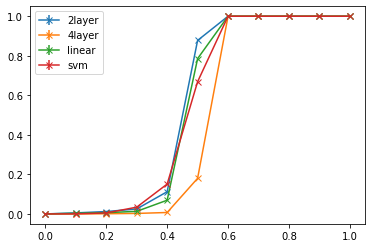

In [4]:
for datatype in ['mnist']:
    save_lipschitz = 'plots/blackbox_' + datatype + '_lipschitz.pk'
    classifiers = ['2layer','4layer','linear','svm']
    L_range = np.arange(0, 1.1, 0.1)
    total_lipschitz = np.zeros(shape=(len(classifiers), len(L_range)))

    mnist = pickle.load(open('data/mnist_10_10_train.pkl', 'rb'))
    data = mnist[1]
    labels = mnist[0]
    x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42)
    x_train = np.array(x_train).reshape(-1, x_train[0].shape[0]*x_train[0].shape[1])
    x_val = np.array(x_val).reshape(-1, x_val[0].shape[0]*x_val[0].shape[1])
    y_train, y_val = np.array(y_train), np.array(y_val)
    y_train_orig, y_val_orig = y_train.copy(), y_val.copy()
    y_train, y_val = to_categorical(y_train), to_categorical(y_val)
    input_shape = x_train.shape[-1]


    median_rad =np.median(pdist(x_train))

    activation = 'relu'

    model_input = Input(shape=(input_shape,), dtype='float32')

    net = Dense(32, activation=activation, name='dense1',
                kernel_regularizer=regularizers.l2(1e-3))(model_input)

    preds = Dense(10, activation='softmax', name='dense3',
                  kernel_regularizer=regularizers.l2(1e-3))(net)
    model = Model(model_input, preds)

    model.load_weights('models/' + datatype + '_blackbox.hdf5',
                           by_name=True)
    pred_model = Model(model_input, preds)
    pred_model.compile(loss=None,
                       optimizer='rmsprop',
                       metrics=None)

    if calculate:
        total_lipschitz[0, :] = calculate_prob_lipschitz(x_val, pred_model,
                                                   r=median_rad,
                                                   L_range=L_range,
                                                   num_points=len(x_val))

    del pred_model

    ###

    print("Training classifier with extra layer")

    activation = 'relu'

    model_input = Input(shape=(input_shape,), dtype='float32')

    net = Dense(32, activation=activation, name='dense1',
                kernel_regularizer=regularizers.l2(1e-3))(model_input)
    net = Dense(32, activation=activation, name='dense2',
                kernel_regularizer=regularizers.l2(1e-3))(net)
    net = Dense(32, activation=activation, name='dense3',
                kernel_regularizer=regularizers.l2(1e-3))(net)
    net = Dense(32, activation=activation, name='dense4',
                kernel_regularizer=regularizers.l2(1e-3))(net)
    preds = Dense(10, activation='softmax', name='dense5',
                  kernel_regularizer=regularizers.l2(1e-3))(net)
    model = Model(model_input, preds)
    model.load_weights('models/' + datatype + '_blackbox_extra.hdf5',
                       by_name=True)
    pred_model = Model(model_input, preds)
    pred_model.compile(loss=None,
                       optimizer='rmsprop',
                       metrics=None)
    if calculate:
        total_lipschitz[1, :] = calculate_prob_lipschitz(x_val, pred_model,
                                                   r=median_rad,
                                                   L_range=L_range,
                                                   num_points=len(x_val))

    del pred_model
    print('Training Linear Classifier')

    activation = None

    model_input = Input(shape=(input_shape,), dtype='float32')

    net = Dense(32, activation=activation, name='dense1',
                kernel_regularizer=regularizers.l2(1e-3))(model_input)

    preds = Dense(10, activation='softmax', name='dense3',
                  kernel_regularizer=regularizers.l2(1e-3))(net)
    model = Model(model_input, preds)

    model.load_weights('models/' + datatype + '_blackbox_linear.hdf5',
                       by_name=True)
    pred_model = Model(model_input, preds)
    pred_model.compile(loss=None,
                       optimizer='rmsprop',
                       metrics=None)


    if calculate:
        total_lipschitz[2, :] = calculate_prob_lipschitz(x_val, pred_model,
                                                   r=median_rad,
                                                   L_range=L_range,
                                                   num_points=len(x_val))

    del pred_model
    ###


    print("SVM")
    svm_classif = pickle.load(open('models/' + datatype + '_svm.pk', 'rb'))

    if calculate:
        total_lipschitz[3, :] = calculate_prob_lipschitz(x_val, svm_classif,
                                                   r=median_rad,
                                                   L_range=L_range,
                                                   num_points=len(x_val),
                                                   NN=False)


    if calculate:
        pickle.dump(total_lipschitz, open(save_lipschitz, 'wb'))
    else:
        total_lipschitz = pickle.load(open(save_lipschitz, 'rb'))

    image_name = 'plots/classifiers_' + datatype + '_lipschitz.PNG'
    plt.figure()
    for i in range(len(classifiers)):
        plt.errorbar(x=L_range, y=total_lipschitz[i, :], yerr=0,
                     label=classifiers[i], marker='x')
    plt.legend()
    plt.savefig(image_name)
    plt.show()
    plt.close()